# 03. Forecasting Model (XGBoost)
**Project:** Climate-Sensitive Health Forecasting (Dengue - Davao Pilot)\
**Author:** Edsequille Publico

### **Goal**
Train a Machine Learning model to predict Dengue cases **1 week in advance**.

### **Strategy**
1.  **Split Data:** Train on 2008–2018, Test on 2019–2023.
2.  **Model:** XGBoost Regressor (Gradient Boosting).
3.  **Evaluation:**
    * **MAE (Mean Absolute Error):** How many cases are we off by?
    * **Visual Check:** Does the red line (prediction) match the blue line (actual)?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# Settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 6)

# Load Features
PROCESSED_DIR = '/kaggle/input/dengue-defensor-features'
INPUT_FILE = os.path.join(PROCESSED_DIR, '02_features.csv')

df = pd.read_csv(INPUT_FILE, index_col='date', parse_dates=True)

print(f"Data Loaded. Shape: {df.shape}")

✅ Data Loaded. Shape: (768, 27)


Training Set: (560, 26) (Before 2019-01-01)
Test Set:     (208, 26) (After 2019-01-01)


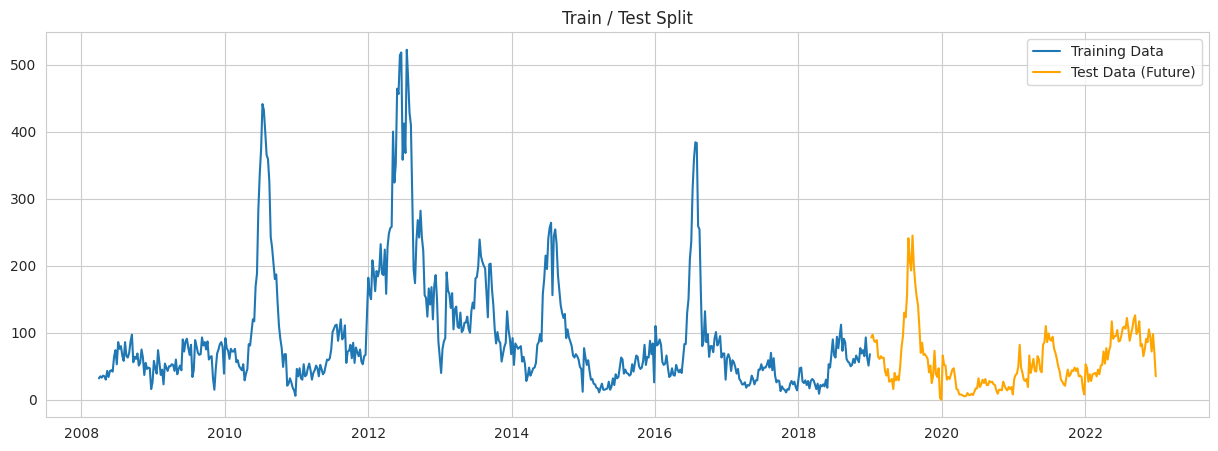

In [4]:
# --- 1. TRAIN / TEST SPLIT ---
# We split by TIME. We cannot use random split because future data can't predict past data.

# Cutoff Date (Pre-Pandemic to avoid COVID anomalies, or include it to see robustness)
# Let's test on the last 3 years of data available.
SPLIT_DATE = '2019-01-01'

train = df[df.index < SPLIT_DATE]
test = df[df.index >= SPLIT_DATE]

# Separate Features (X) and Target (y)
# Drop 'cases' because that's the answer we want to predict
X_train = train.drop(columns=['cases'])
y_train = train['cases']

X_test = test.drop(columns=['cases'])
y_test = test['cases']

print(f"Training Set: {X_train.shape} (Before {SPLIT_DATE})")
print(f"Test Set:     {X_test.shape} (After {SPLIT_DATE})")

# Visual check of the split
plt.figure(figsize=(15, 5))
plt.plot(train.index, y_train, label='Training Data')
plt.plot(test.index, y_test, label='Test Data (Future)', color='orange')
plt.legend()
plt.title('Train / Test Split')
plt.show()

In [ ]:
# --- 2. MODEL TRAINING ---

# Initialize XGBoost Regressor
# These hyperparameters are a good starting point for time series
model = xgb.XGBRegressor(
    n_estimators=1000,      # Maximum number of trees
    learning_rate=0.01,     # Slow learning prevents overfitting
    max_depth=5,            # Depth of each tree
    subsample=0.8,          # Train on 80% of rows (prevents overfitting)
    colsample_bytree=0.8,   # Train on 80% of columns
    early_stopping_rounds=50, # Stop if validation error doesn't improve
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

# Train the model
# We use the Test set as 'eval_set' to monitor performance live
print("Training Model...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100  # Print update every 100 trees
)

print("Model Trained Successfully.")

Training Model...
[0]	validation_0-rmse:89.36609	validation_1-rmse:57.25442
[100]	validation_0-rmse:40.15074	validation_1-rmse:28.42350
[200]	validation_0-rmse:20.91207	validation_1-rmse:19.87839
[300]	validation_0-rmse:13.57158	validation_1-rmse:17.91933
[400]	validation_0-rmse:10.50442	validation_1-rmse:17.45700
[500]	validation_0-rmse:8.85346	validation_1-rmse:17.32752
[600]	validation_0-rmse:7.63213	validation_1-rmse:17.25845
[700]	validation_0-rmse:6.63036	validation_1-rmse:17.21163
[748]	validation_0-rmse:6.17948	validation_1-rmse:17.22406
✅ Model Trained Successfully.



--- PERFORMANCE METRICS ---
Mean Absolute Error (MAE): 13.20
Root Mean Squared Error (RMSE): 17.21
Explanation: On average, the model is off by 13 cases per week.


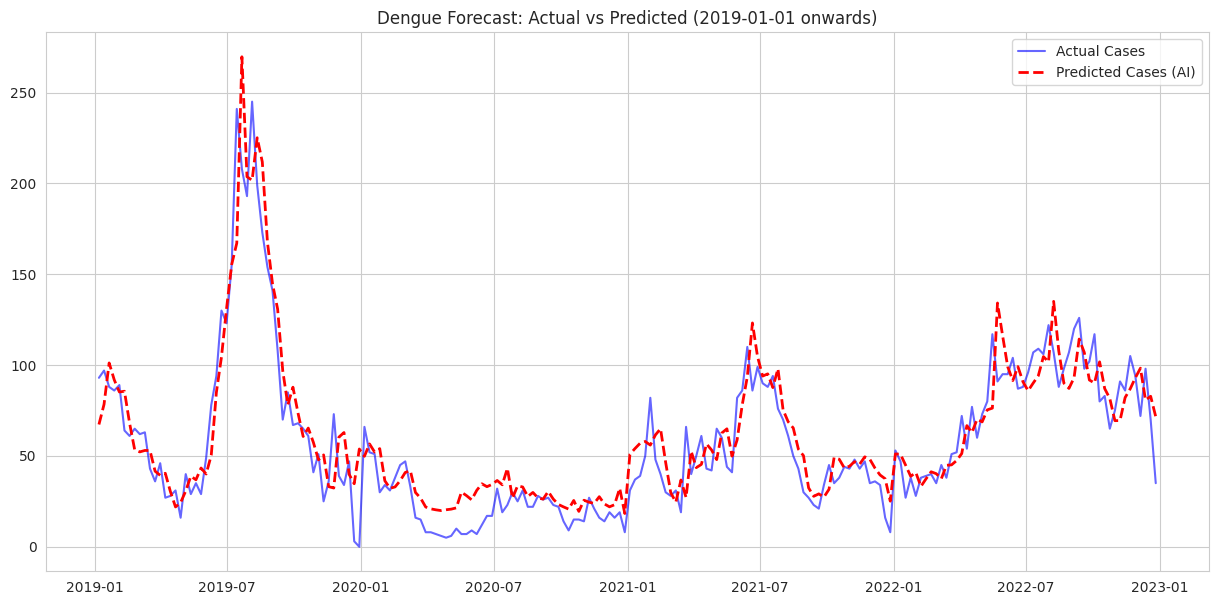

In [6]:
# --- 3. EVALUATION ---

# Make Predictions
# The model predicts the 'Test' set
y_pred = model.predict(X_test)

# Calculate Error Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n--- PERFORMANCE METRICS ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Explanation: On average, the model is off by {mae:.0f} cases per week.")

# Plot Actual vs Predicted
plt.figure(figsize=(15, 7))
plt.plot(test.index, y_test, label='Actual Cases', color='blue', alpha=0.6)
plt.plot(test.index, y_pred, label='Predicted Cases (AI)', color='red', linestyle='--', linewidth=2)

plt.title(f'Dengue Forecast: Actual vs Predicted ({SPLIT_DATE} onwards)')
plt.legend()
plt.show()

/tmp/ipykernel_55/3676109673.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance.head(15), palette='viridis')


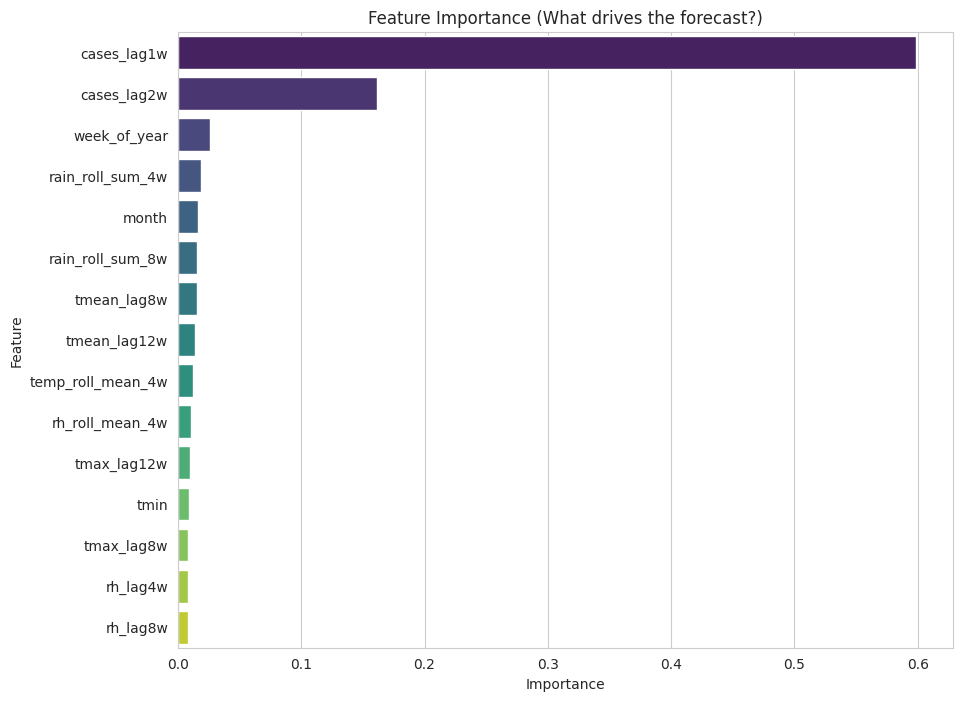

In [7]:
# --- 4. FEATURE IMPORTANCE ---
# What features did the AI find most useful?

importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance.head(15), palette='viridis')
plt.title('Feature Importance (What drives the forecast?)')
plt.show()

In [ ]:
# --- 5. SAVE MODEL ---
# Save the trained model to use later (e.g., in a web app)

import joblib

MODEL_DIR = '/kaggle/working/'
os.makedirs(MODEL_DIR, exist_ok=True)
model_path = os.path.join(MODEL_DIR, 'dengue_xgboost_v1.pkl')

joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

✅ Model saved to: /kaggle/working/dengue_xgboost_v1.pkl
